In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# --- SETTINGS ---
filepath = "optimization/results/beam_search_old_parents_included_1e5_run1.hdf5"
code_names = ["[625,25]", "[1225,65]", "[1600,64]", "[2025,81]"]
BEAM_WIDTH = 3
PARENT_COLORS = ['tab:orange', 'tab:purple', 'tab:pink']


def process_and_plot_on_axis(ax, grp, code_name):
    """
    Helper function that handles data extraction and plotting for a single code 
    on a specific matplotlib axis (ax).
    """
    # --- DATA LOADING ---
    lers = grp["logical_error_rates"][:]
    stds = grp["logical_error_rates_std"][:]
    summaries = grp["step_summaries"][:]
    survivor_indices_table = grp["beam_survivors"][:]

    # --- STATISTICS & PRINTING ---
    evaluated_lers = np.where(lers > 0, lers, np.inf)
    min_idx = np.argmin(evaluated_lers)

    # Check if we have valid data
    if np.isinf(evaluated_lers[min_idx]):
        print(f"[{code_name}] No evaluated error rates found (all zeros).")
        ax.text(0.5, 0.5, "No Data Evaluated",
                transform=ax.transAxes, ha='center')
        return

    min_ler = evaluated_lers[min_idx]
    print(
        f"[{code_name}] Best LER: {min_ler:.5f} ± {stds[min_idx]:} (index {min_idx})")

    if "total_runtime" in grp.attrs:
        rt = grp.attrs['total_runtime']
        print(
            f"[{code_name}] Runtime: {int(rt // 3600)}h {int(rt % 3600 // 60)}m {int(rt % 60)}s")

    if "parent_idx" in grp:
        parent_indices = grp["parent_idx"][:]
    else:
        print(
            f"Warning: 'parent_idx' not found for {code_name}. Defaulting to 0.")
        parent_indices = np.zeros(len(lers), dtype=int)

    # --- DATA ALIGNMENT ---
    steps_data = []
    num_steps = grp.attrs['L']

    for i in range(num_steps):
        row = summaries[i]
        start_idx = int(row[0])
        count = int(row[1])

        # 1. The Cloud (Candidates evaluated this step)
        cloud_lers = lers[start_idx: start_idx + count]
        cloud_stds = stds[start_idx: start_idx + count]
        cloud_parents = parent_indices[start_idx: start_idx + count]

        # 2. The Survivors (Winners chosen to be next parents)
        step_survivor_indices = survivor_indices_table[i]
        step_survivors = []
        for global_idx in step_survivor_indices:
            # Check validity and ensure > 0
            if global_idx != -1 and global_idx < len(lers) and lers[global_idx] > 0:
                step_survivors.append((lers[global_idx], stds[global_idx]))

        best_of_step = min(
            step_survivors, key=lambda x: x[0]) if step_survivors else None

        steps_data.append({
            "step_num": i+1,
            "cloud_lers": cloud_lers,
            "cloud_stds": cloud_stds,
            "cloud_parents": cloud_parents,
            "survivors": step_survivors,
            "best_of_step": best_of_step
        })

    # --- PLOTTING ---

    # 1. Plot the "Search Cloud" (Colored by Parent)
    for data in steps_data:
        step_x = data["step_num"]

        # Mask zeros for log plotting
        mask = data["cloud_lers"] > 0
        valid_lers = data["cloud_lers"][mask]
        valid_stds = data["cloud_stds"][mask]
        valid_parents = data["cloud_parents"][mask]

        if len(valid_lers) > 0:
            x_vals = np.ones(len(valid_lers)) * step_x
            jitter = np.random.normal(0, 0.06, size=len(x_vals))

            for p_id in range(BEAM_WIDTH):
                p_mask = (valid_parents == p_id)
                if np.any(p_mask):
                    ax.errorbar(x_vals[p_mask] + jitter[p_mask],
                                valid_lers[p_mask],
                                yerr=valid_stds[p_mask],
                                fmt='o',
                                color=PARENT_COLORS[p_id % len(PARENT_COLORS)],
                                alpha=0.6,
                                ms=2,
                                zorder=0,
                                label=f'Child of P{p_id}' if step_x == 2 else "")

    # 2. Plot Survivors (Blue Dots)
    for data in steps_data:
        step_x = data["step_num"]
        for survivor in data["survivors"]:
            ax.errorbar(step_x, survivor[0], yerr=survivor[1],
                        fmt='o', color='tab:blue', alpha=1.0, ms=4, zorder=1,
                        label='Parents' if step_x == 1 else "")

    # 3. Plot Best Path (Green Line)
    best_x = []
    best_y = []
    best_yerr = []

    for data in steps_data:
        if data["best_of_step"]:
            best_x.append(data["step_num"])
            best_y.append(data["best_of_step"][0])
            best_yerr.append(data["best_of_step"][1])

    if best_x:
        ax.plot(best_x, best_y, color='tab:blue',
                linestyle='-', linewidth=1.5, zorder=2)

        # Mark Overall Best
        min_y_val = min(best_y)
        already_labeled = False
        for k in range(len(best_x)):
            if best_y[k] == min_y_val:
                label_txt = 'Overall Best' if not already_labeled else ""
                ax.plot(best_x[k], best_y[k], marker='*', color='green',
                        markersize=12, zorder=4, label=label_txt)
                already_labeled = True

    # --- STYLING ---
    ax.set_xticks(np.arange(1, num_steps + 1))
    ax.set_yscale('log')
    ax.set_xlabel('Step $l$')
    ax.set_ylabel('Logical Error Rate $p_L$')
    ax.set_title(f'Code: [{code_name}]')
    ax.grid(True, which="both", ls="-", alpha=0.2)

    # Dedup legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(),
              loc='upper right', fontsize='small')


def plot_subplots(filepath, code_names):
    """Plots all codes in a single 2x2 figure."""
    print(f"\n--- GENERATING SUBPLOTS ---")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    with h5py.File(filepath, "r") as f:
        for idx, code_name in enumerate(code_names):
            if idx >= len(axes):
                break
            ax = axes[idx]

            if code_name not in f:
                print(f"Code {code_name} not found.")
                ax.text(0.5, 0.5, f"{code_name} Not Found",
                        ha='center', transform=ax.transAxes)
                continue

            process_and_plot_on_axis(ax, f[code_name], code_name)

    plt.suptitle(f"Beam Search Results (Subplots)", fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_separate(filepath, code_names):
    """Plots each code in its own distinct figure."""
    print(f"\n--- GENERATING SEPARATE PLOTS ---")
    with h5py.File(filepath, "r") as f:
        for code_name in code_names:
            if code_name not in f:
                print(f"Code {code_name} not found.")
                continue

            # Create a new figure for each code
            fig, ax = plt.subplots(figsize=(10, 7))

            process_and_plot_on_axis(ax, f[code_name], code_name)

            plt.suptitle(f"Beam Search Results: [{code_name}]", fontsize=14)
            plt.tight_layout()
            plt.show()

# if __name__ == "__main__":
#     # You can comment out one of these lines if you only want one type of plot
#     plot_subplots(filepath, code_names)
#     plot_separate(filepath, code_names)


--- GENERATING SEPARATE PLOTS ---
[[625,25]] Best LER: 0.00362 ± 0.00018991923729092566 (index 997)
[[625,25]] Runtime: 4h 55m 48s


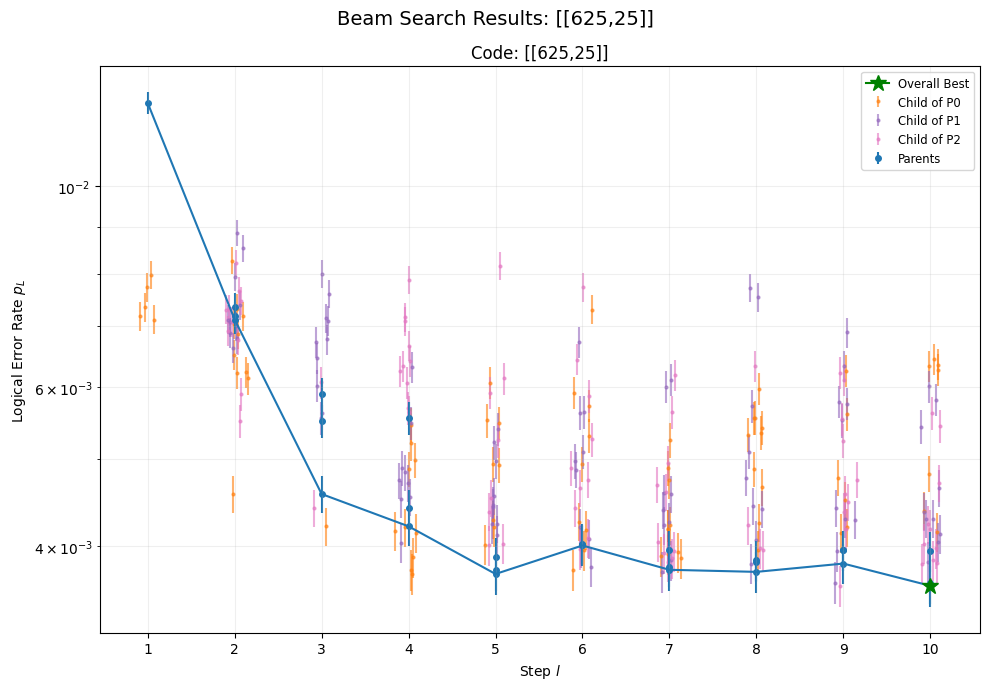

In [58]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Settings
filepath = "optimization/results/beam_search_N=50.hdf5"
code_name = "[625,25]"  # Update this key if needed
BEAM_WIDTH = 3             

plot_separate(filepath, code_names=[code_name])

In [59]:
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state
from optimization.experiments_settings import from_edgelist

filepath = "optimization/results/beam_search_N=50.hdf5"
code_name = "[625,25]"  # Update this key if needed
MC_budget = int(1e5)
p = 0.03

with h5py.File(filepath, "r") as f:
    grp = f[code_name]
        
    # Load datasets
    best_state_edge_list = grp["best_state"][:]
    best_state = from_edgelist(best_state_edge_list)

    print(f"Best state edge list: {best_state_edge_list}")

    cost_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, canskip=False)

Best state edge list: [[ 0 15  0 24  0 30  0 32  1 15  1 21  1 22  1 25  2 15  2 26  2 31  2 32
   2 34  3 16  3 20  3 26  3 31  4 16  4 22  4 25  4 30  5 16  5 20  5 23
   5 27  6 17  6 20  6 27  6 33  7 17  7 22  7 28  7 31  8 17  8 23  8 29
   8 30  9 18  9 18  9 28  9 32 10 18 10 23 10 26 10 33 11 21 11 24 11 29
  11 34 12 19 12 21 12 27 12 34 13 19 13 24 13 28 13 33 14 19 14 25 14 29]]
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]
Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625


/Users/manyyeon/data/git/optimizing-qLDPC-code/.venv/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


Decoder Best neighbor search finished in 1.0m 8.60s with 390 failures out of 100000 runs.
Logical error rate for Best neighbor search: 0.0039 ± 0.0001971 (stderr)


In [ ]:
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state
from optimization.experiments_settings import from_edgelist

filepath = "optimization/results/best_neighbor_search_early_stop.hdf5"
code_name = "[625,25]"  # Update this key if needed
MC_budget = int(1e5)
p = 0.03

with h5py.File(filepath, "r") as f:
    grp = f[code_name]
    
    # Load datasets
    best_state_edge_list = grp["best_state"][:]
    best_state = from_edgelist(best_state_edge_list)

    print(f"Best state edge list: {best_state_edge_list}")

    cost_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, canskip=False)

Best state edge list: [[ 0 20  0 20  0 24  0 30  1 15  1 21  1 25  1 31  2 15  2 22  2 26  2 28
   2 34  3 15  3 16  3 26  3 31  4 16  4 22  4 25  4 30  5 16  5 23  5 28
   5 32  6 17  6 20  6 27  6 33  7 17  7 22  7 27  7 31  8 17  8 21  8 23
   8 30  9 21  9 28  9 32  9 33 10 18 10 18 10 23 10 26 11 18 11 24 11 29
  11 34 12 19 12 27 12 29 12 34 13 19 13 24 13 32 13 33 14 19 14 25 14 29]]
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]
Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Best neighbor search finished in 1.0m 16.67s with 345 failures out of 100000 runs.
Logical error rate for Best neighbor search: 0.00345 ± 0.0001854 (stderr)


In [27]:
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state
from optimization.experiments_settings import from_edgelist

filepath = "optimization/results/best_neighbor_search_early_stop.hdf5"
code_name = "[625,25]"  # Update this key if needed
MC_budget = int(1e5)
p = 0.03

with h5py.File(filepath, "r") as f:
    grp = f[code_name]
    
    # Load datasets
    best_state_edge_list = grp["best_state"][:]
    best_state = from_edgelist(best_state_edge_list)

    print(f"Best state edge list: {best_state_edge_list}")

for i in range(5):
    cost_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, canskip=False)

Best state edge list: [[ 0 20  0 20  0 24  0 30  1 15  1 21  1 25  1 31  2 15  2 22  2 26  2 28
   2 34  3 15  3 16  3 26  3 31  4 16  4 22  4 25  4 30  5 16  5 23  5 28
   5 32  6 17  6 20  6 27  6 33  7 17  7 22  7 27  7 31  8 17  8 21  8 23
   8 30  9 21  9 28  9 32  9 33 10 18 10 18 10 23 10 26 11 18 11 24 11 29
  11 34 12 19 12 27 12 29 12 34 13 19 13 24 13 32 13 33 14 19 14 25 14 29]]
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Best neighbor search finished in 1.0m 17.55s with 339 failures out of 100000 runs.
Logical error rate for Best neighbor search: 0.00339 ± 0.0001838 (stderr)
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]
Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Best neighbor search finished in 1.0m 16.86s with 364 failures out of 100000 runs.
Logical error rate for Best neighbor search: 0.00364 ± 0.0001904 (stderr)
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]
Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Best neighbor search finished in 1.0m 16.25s with 337 failures out of 100000 runs.
Logical error rate for Best neighbor search: 0.00337 ± 0.0001833 (stderr)
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [

In [25]:
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state
from optimization.experiments_settings import from_edgelist

filepath = "optimization/results/beam_search_N=50.hdf5"
code_name = "[625,25]"  # Update this key if needed
MC_budget = int(1e5)
p = 0.03

with h5py.File(filepath, "r") as f:
    grp = f[code_name]
        
    # Load datasets
    best_state_edge_list = grp["best_state"][:]
    best_state = from_edgelist(best_state_edge_list)

for i in range(5):
    cost_result = evaluate_performance_of_state(state=best_state, p_vals=[p], MC_budget=MC_budget, canskip=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ldpc/code_util/code_util.py:164: UserWarning: This function has exponential complexity. Not recommended for large pcms. Use the                            'ldpc.code_util.estimate_code_distance' function instead.
  warnings.warn(


H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]
Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Best neighbor search finished in 1.0m 14.02s with 412 failures out of 100000 runs.
Logical error rate for Best neighbor search: 0.00412 ± 0.0002026 (stderr)
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]
Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Best neighbor search finished in 1.0m 13.71s with 433 failures out of 100000 runs.
Logical error rate for Best neighbor search: 0.00433 ± 0.0002076 (stderr)
H: [20, 5, 8]
H^T: [15, 0, inf]
Q: [[625, 25, 8]]
Hx, Hz, Lx, Lz: (300, 625), (300, 625), (25, 625), (25, 625)
BP max iterations: 62, OSD order: 2, MS scaling factor: 0.625
Decoder Best neighbor search finished in 1.0m 12.61s with 418 failures out of 100000 runs.
Logical error rate for Best neighbor search: 0.00418 ± 0.000

In [28]:
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state
from optimization.experiments_settings import from_edgelist

filepath = "optimization/results/beam_search_N=50.hdf5"
code_name = "[625,25]"  # Update this key if needed
MC_budget = int(1e5)
p = 0.03

with h5py.File(filepath, "r") as f:
    grp = f[code_name]
        
    # Load datasets
    best_state_edge_list = grp["best_state"][:]
    best_state = from_edgelist(best_state_edge_list)

    print(f"Best state edge list: {best_state_edge_list}")

Best state edge list: [[ 0 15  0 24  0 30  0 32  1 15  1 21  1 22  1 25  2 15  2 26  2 31  2 32
   2 34  3 16  3 20  3 26  3 31  4 16  4 22  4 25  4 30  5 16  5 20  5 23
   5 27  6 17  6 20  6 27  6 33  7 17  7 22  7 28  7 31  8 17  8 23  8 29
   8 30  9 18  9 18  9 28  9 32 10 18 10 23 10 26 10 33 11 21 11 24 11 29
  11 34 12 19 12 21 12 27 12 34 13 19 13 24 13 28 13 33 14 19 14 25 14 29]]


# Beam Search + Multi Parents + Old Parents Run1


--- GENERATING SUBPLOTS ---
[[625,25]] Best LER: 0.00386 ± 0.00019609025604013357 (index 976)
[[625,25]] Runtime: 4h 49m 24s
[[1225,65]] Best LER: 0.00178 ± 0.00013329851343858582 (index 971)
[[1225,65]] Runtime: 11h 55m 33s
[[1600,64]] Best LER: 0.00135 ± 0.00011611162654574344 (index 547)
[[1600,64]] Runtime: 21h 44m 0s
[[2025,81]] Best LER: 0.00080 ± 8.940738189209751e-05 (index 773)
[[2025,81]] Runtime: 15h 20m 53s


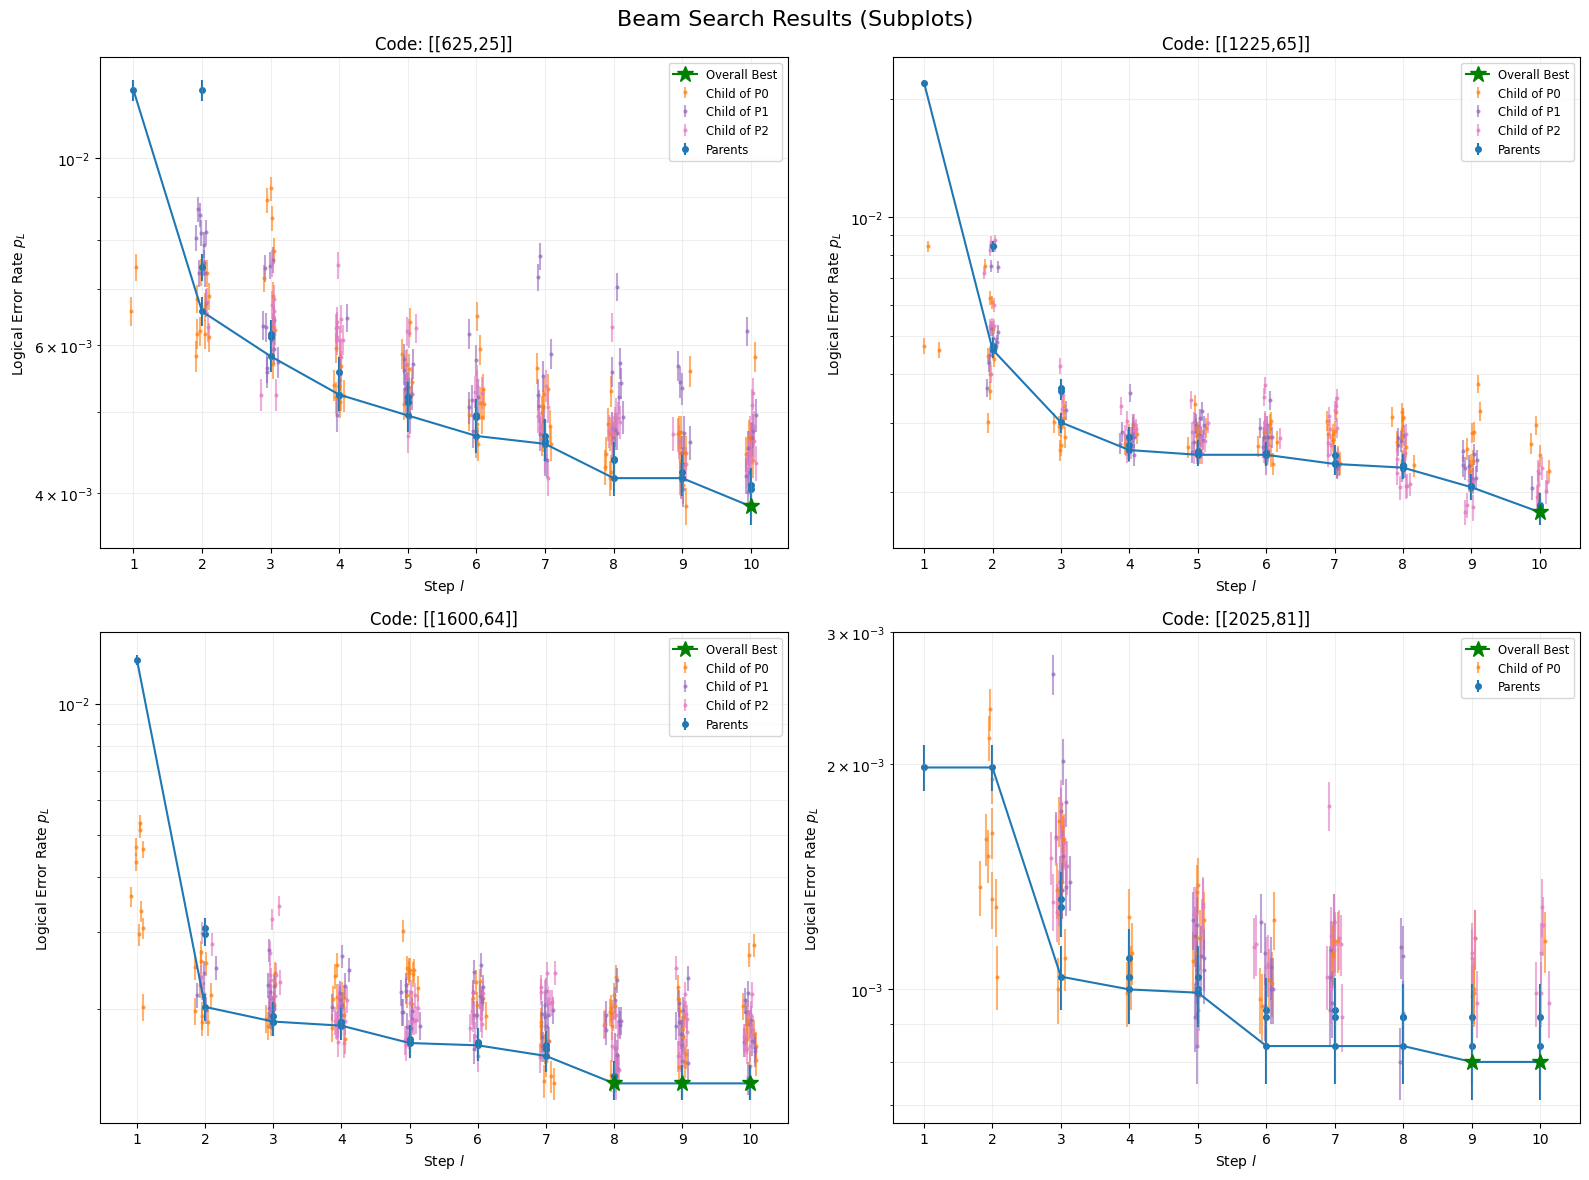

In [60]:
# Settings
filepath = "optimization/results/beam_search_old_parents_included_1e5_run1.hdf5"
# Note: I kept your list, but check if [1225,25655] is a typo for [1225,25]
code_names = ["[625,25]", "[1225,65]", "[1600,64]", "[2025,81]"]
BEAM_WIDTH = 3    

plot_subplots(filepath, code_names)

# Beam Search + Multi Parents + Old Parents Run2


--- GENERATING SEPARATE PLOTS ---
[[625,25]] Best LER: 0.00422 ± 0.00020499350288085284 (index 1113)
[[625,25]] Runtime: 5h 12m 52s


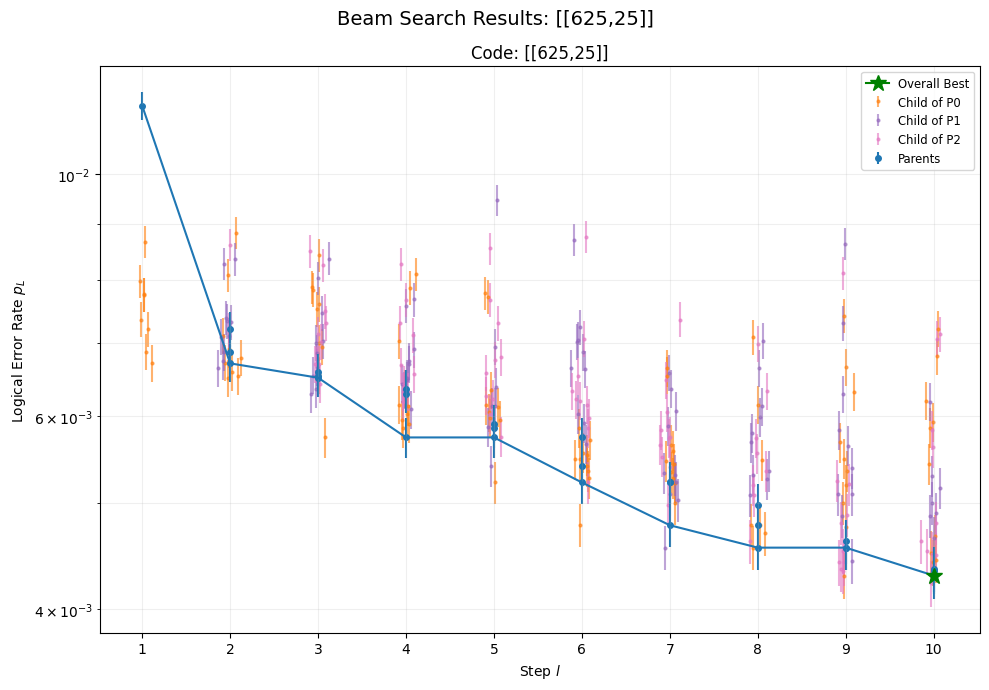

In [61]:
# Settings
filepath = "optimization/results/beam_search_old_parents_included_1e5_run2.hdf5"
code_names = ["[625,25]"]
BEAM_WIDTH = 3    

plot_separate(filepath, code_names)


--- GENERATING SEPARATE PLOTS ---
[[625,25]] Best LER: 0.00420 ± 0.00020450921309364626 (index 1093)
[[625,25]] Runtime: 4h 35m 42s


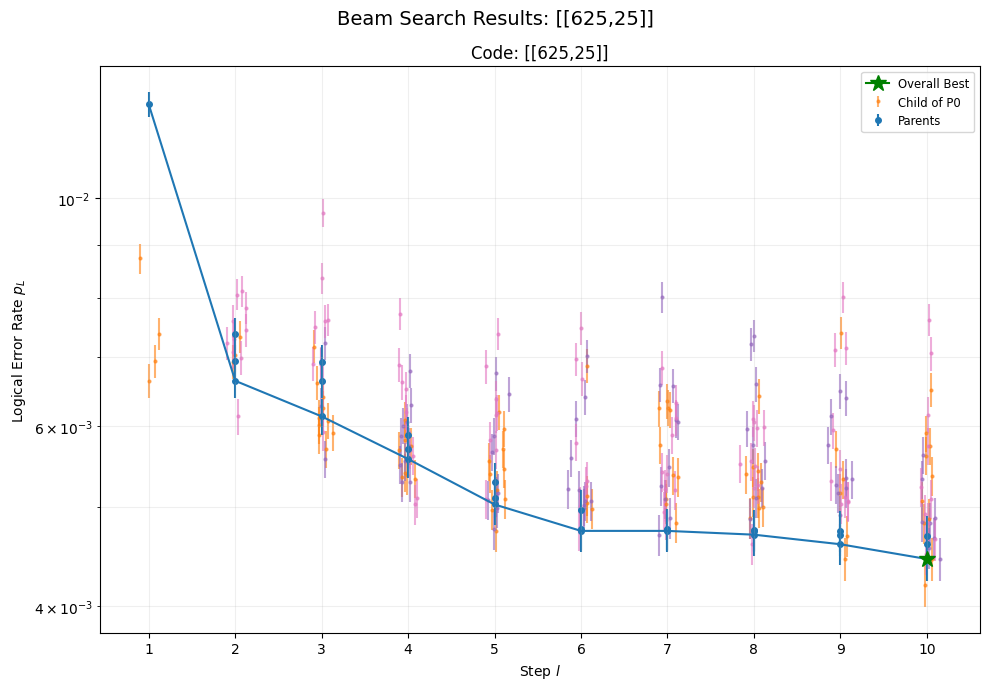

In [56]:
# Settings
filepath = "optimization/results/beam_search_old_parents_included_1e5_run3.hdf5"
code_names = ["[625,25]"]
BEAM_WIDTH = 3    

plot_separate(filepath, code_names)


--- GENERATING SEPARATE PLOTS ---
[[625,25]] Best LER: 0.00314 ± 0.00017692291264042134 (index 1566)
[[625,25]] Runtime: 7h 56m 50s


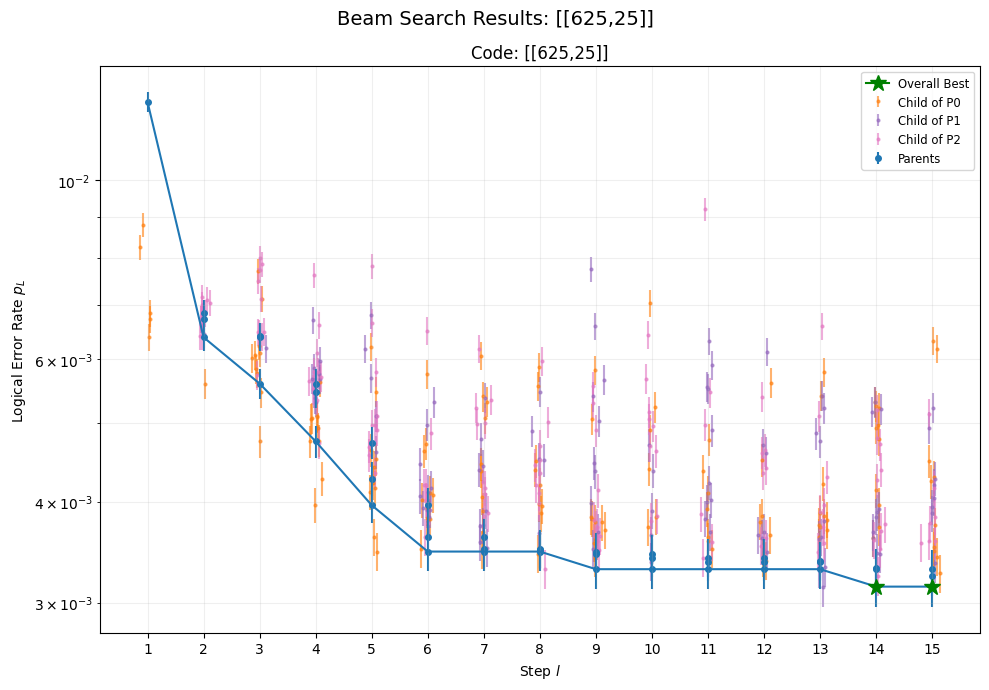

[[1225,65]] Best LER: 0.00180 ± 0.00013404394681520225 (index 572)
[[1225,65]] Runtime: 21h 29m 5s


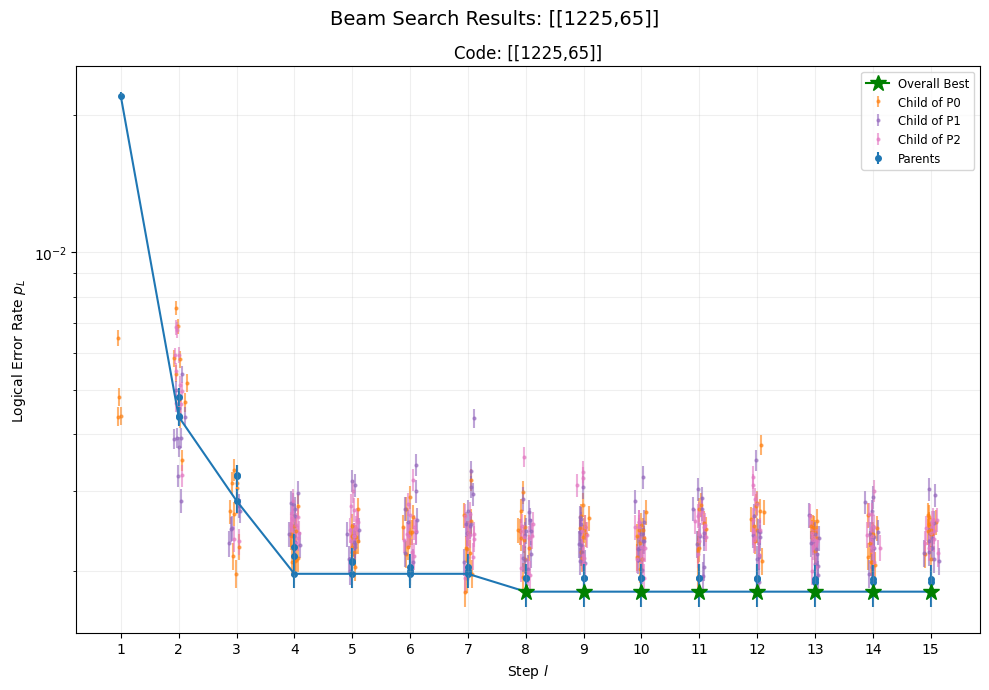

In [3]:
# Settings
filepath = "optimization/results/beam_search_L15_old_parents_included_1e5_run1.hdf5"
code_names = ["[625,25]", "[1225,65]"]
BEAM_WIDTH = 3

plot_separate(filepath, code_names)

In [64]:
from optimization.analyze_codes.decoder_performance_from_state import evaluate_performance_of_state
from optimization.experiments_settings import from_edgelist

filepath = "optimization/results/beam_search_L15_old_parents_included_1e5_run1.hdf5"
code_name = "[625,25]"  # Update this key if needed
MC_budget = int(1e5)
p = 0.03

with h5py.File(filepath, "r") as f:
    grp = f[code_name]

    # Load datasets
    best_state_edge_list = grp["best_state"][:]
    best_state = from_edgelist(best_state_edge_list)

    print(best_state_edge_list)

# for i in range(5):
#     cost_result = evaluate_performance_of_state(
#         state=best_state, p_vals=[p], MC_budget=MC_budget, canskip=False)

[[ 0 20  0 25  0 28  0 30  1 15  1 21  1 21  1 31  2 15  2 22  2 26  2 32
   2 34  3 16  3 20  3 27  3 31  4 16  4 22  4 25  4 30  5 16  5 23  5 27
   5 32  6 17  6 20  6 27  6 33  7 17  7 22  7 29  7 33  8 17  8 30  8 31
   8 34  9 18  9 21  9 28  9 32 10 18 10 23 10 26 10 33 11 18 11 24 11 29
  11 34 12 15 12 19 12 23 12 26 13 19 13 24 13 24 13 28 14 19 14 25 14 29]]
